# Pileups \#2

In [ ]:
# downloading Hi-C data: beware, it is 21Gb big!

In [1]:
%%bash
mkdir -p /tmp/pileup-example/
wget https://data.4dnucleome.org/files-processed/4DNFIB59T7NN/@@download/4DNFIB59T7NN.mcool -qO /tmp/pileup-example/HFFc6_DpnII.mcool
wget https://www.encodeproject.org/files/ENCFF401MQL/@@download/ENCFF401MQL.bed.gz -qO /tmp/pileup-example/HFF_Myc_CTCF_encode.conservative_idr_peaks.bed.gz

In [77]:
import numpy as np

import pandas as pd

import matplotlib
import matplotlib.gridspec
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['svg.fonttype'] = 'none' # No text as paths. Assume font installed.

plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.usetex'] = False

%config Completer.use_jedi = False

In [2]:
import bioframe
import cooler
import cooltools
import cooltools.expected

In [3]:
import bioframe

chromsizes = bioframe.fetch_chromsizes('hg38')
cens = bioframe.fetch_centromeres('hg38')
cens.set_index('chrom', inplace=True)
cens = cens.mid

GOOD_CHROMS = list(chromsizes.index[:23])

arms = [arm 
        for chrom in GOOD_CHROMS
        for arm in ((chrom, 0, cens.get(chrom,0)), 
                    (chrom, cens.get(chrom,0), chromsizes.get(chrom,0)))
]
arms = pd.DataFrame(arms, columns=['chrom','start', 'end'])

In [64]:
BINSIZE = 2000
clr=cooler.Cooler(f'/tmp/pileup-example/HFFc6_DpnII.mcool::/resolutions/{BINSIZE}')

In [6]:
import multiprocess

with multiprocess.Pool(20) as pool:
    expected = cooltools.expected.diagsum(
        clr, 
        list(arms.itertuples(index=False,name=None)), 
        transforms={
            'balanced': lambda p: p['count'] * p['weight1'] * p['weight2']
        },
    map=pool.map
    )

In [30]:
expected_df = pd.concat([
    exp.reset_index().assign(chrom=reg[0], start=reg[1], end=reg[2])
    for reg, exp in expected.items()])

expected_df = expected_df.groupby(('chrom','diag')).aggregate({
    'n_valid':'sum',
    'count.sum':'sum',
    'balanced.sum':'sum'}).reset_index()

expected_df['balanced.avg'] = expected_df['balanced.sum'] / expected_df['n_valid']

/home/golobor/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """


In [8]:
import pybedtools
ctcf_peaks = pybedtools.BedTool('/tmp/pileup-example/HFF_Myc_CTCF_encode.conservative_idr_peaks.bed.gz').sort()
ctcf_motifs = pybedtools.BedTool('./encode_motifs.hg38.ctcf_known1.liftover.bed.gz').sort()
ctcf_motifs_w_peaks = ctcf_motifs.intersect(ctcf_peaks).to_dataframe()
ctcf_motifs_w_peaks['mid'] = (ctcf_motifs_w_peaks.start + ctcf_motifs_w_peaks.end) / 2

/home/golobor/miniconda3/lib/python3.7/site-packages/pybedtools/bedtool.py:3439: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  return pandas.read_table(self.fn, *args, **kwargs)


In [9]:
import cooltools.snipping

WINDOW_HALF_SIZE = 100000
snipping_windows = cooltools.snipping.make_bin_aligned_windows(
    BINSIZE,
    ctcf_motifs_w_peaks.chrom.values,
    ctcf_motifs_w_peaks.mid.values,
    WINDOW_HALF_SIZE
)

snipping_windows = cooltools.snipping.assign_regions(
    snipping_windows, 
    list(arms.itertuples(index=False,name=None)))

In [59]:
# ICCF_snipper = cooltools.snipping.CoolerSnipper(clr)

# with multiprocess.Pool(20) as pool:
#     ICCF_pile = cooltools.snipping.pileup(
#             snipping_windows, 
#             ICCF_snipper.select, ICCF_snipper.snip,
#             map=pool.map)

In [33]:
oe_snipper = cooltools.snipping.ObsExpSnipper(clr, expected_df)

with multiprocess.Pool(20) as pool:
    oe_pile = cooltools.snipping.pileup(
            snipping_windows, 
            oe_snipper.select, oe_snipper.snip,
            map=pool.map)

In [75]:
collapsed_pile_plus = np.nanmean(
    oe_pile[:, :, ctcf_motifs_w_peaks.strand=='+'], axis=2
)
collapsed_pile_minus = np.nanmean(
    oe_pile[:, :, ctcf_motifs_w_peaks.strand=='-'], axis=2
)

Text(0, 0.5, 'relative position, kbp')

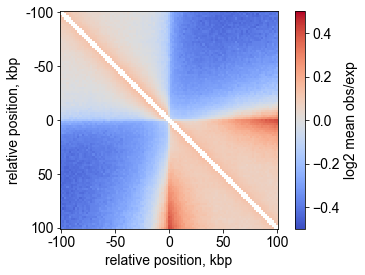

In [78]:
plt.imshow(
    np.log2(collapsed_pile_plus), 
    vmax = 0.5, 
    vmin = -0.5,
    cmap='coolwarm')
plt.colorbar(label = 'log2 mean obs/exp')
ticks_pixels = np.linspace(0, WINDOW_HALF_SIZE*2//BINSIZE,5)
ticks_kbp = ((ticks-ticks[-1]/2)*BINSIZE//1000).astype(int)
plt.xticks(ticks_pixels, ticks_kbp)
plt.yticks(ticks_pixels, ticks_kbp)
plt.xlabel('relative position, kbp')
plt.ylabel('relative position, kbp')